In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

In [59]:
from sklearn.metrics import classification_report

# Implementação

In [80]:
def regression(X, Yt, k):
    _, d = X.shape

    Xt = np.hstack([X, np.ones((len(X), 1))])
    W = np.random.rand(k, d+1)/5

    S = sigmoid(Xt, W).flatten()
    erro = S - Yt
    grad = np.matmul(erro.T, Xt)
    norm = np.linalg.norm(grad.flatten())
    
    idx = 0
    idx_max = 10000
    
    errors = []
    while norm > 1e-5 and idx <= idx_max:
        S = sigmoid(Xt, W).flatten()
        erro = S - Yt
        grad = np.matmul(erro.T, Xt)
        norm = np.linalg.norm(grad.flatten())

        alpha = bisection(W, grad, Xt, Yt)
        W = W - alpha * grad

        loss = binary_cross_entropy(Yt, S)      
        errors.append(loss)
        
        # print(f"it: {idx}, grad_norm: {norm}, cross_entropy: {loss}\n")
        idx += 1
        
    plot.plot(errors)
    
    return W, errors[-1]

In [83]:
def bisection(W, grad, Xt, Yt): 
    def alpha_gen():
        alpha_g = np.random.rand()
        while h_l(alpha_g, W, grad, Xt, Yt) < 0:
            alpha_g = alpha_g * 2

        return alpha_g

    alpha_l = 0
    alpha_u = alpha_gen()
    alpha = (alpha_l + alpha_u) / 2

    hl = h_l(alpha, W, grad, Xt, Yt)

    it = 0
    it_max = int(np.ceil(np.log(alpha_u - alpha_l) - np.log(1e-5))/np.log(2))
    while (it < it_max):
        it += 1
        if hl > 0:
            alpha_u = alpha
        elif hl < 0:
            alpha_l = alpha

        alpha = (alpha_l + alpha_u) / 2
        hl = h_l(alpha, W, grad, Xt, Yt)

    return alpha

In [78]:
def h_l(alpha, W, grad, Xt, Yt):
    Wi = W - alpha * grad
    S = sigmoid(Xt, Wi).flatten()
    
    erro = S - Yt
    grad_alpha = np.matmul(erro.T, Xt).flatten()

    return np.dot(grad_alpha.T, -grad.flatten())

In [5]:
def sigmoid(Xt, W):
    S = np.matmul(Xt, W.T)
    return 1/(1 + np.exp(-S))

In [6]:
def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [58]:
def predict(W, X):
    Xt = np.hstack([X, np.ones((len(X), 1))])
    return sigmoid(Xt, W).flatten()

# Execução

Aplicação dos modelos para datasets.

## HOG

In [24]:
df = pd.read_parquet(r'../../data/preprocessed/feature_matrix_hog.parquet')

In [25]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,match
0,2.306814,3.954538,3.624993,3.460221,2.636359,3.130676,2.636359,2.306814,1.647724,2.636359,...,0.295641,0.000000,0.295641,0.000000,0.000000,0.147820,0.000000,0.000000,0.147820,True
1,2.193303,2.976625,3.759947,3.603283,4.073276,4.073276,1.253316,1.409980,2.349967,0.939987,...,0.500357,0.333572,0.333572,0.000000,0.333572,0.000000,0.500357,0.000000,0.166786,True
2,3.875630,3.720604,3.100504,3.410554,3.100504,4.030655,1.860302,1.860302,1.550252,1.395227,...,0.482976,0.160992,0.321984,0.160992,0.321984,0.160992,0.160992,0.160992,0.160992,True
3,4.624305,3.545300,3.545300,2.466296,3.391157,2.928726,1.849722,2.158009,1.387291,1.695578,...,0.132290,0.132290,0.132290,0.000000,0.000000,0.000000,0.132290,0.000000,0.132290,True
4,2.934841,4.255520,4.549004,3.962035,3.521809,1.614163,1.614163,1.467421,0.733710,1.173936,...,0.501895,0.167298,0.167298,0.334597,0.167298,0.167298,0.000000,0.000000,0.334597,True


In [69]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

In [70]:
X.shape

(3197, 59)

In [71]:
y = [int(tag is True) for tag in y]

In [72]:
y = np.array(y)

Separando dados de treino e teste.

In [31]:
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Utilizando apenas dados de treino para seleção do número de neurônios para treinamneto final.

In [74]:
# número de saídas
k = 1

/var/folders/bl/_mb22ns55vs2vl4n587ksnr00000gp/T/ipykernel_30260/553739335.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-S))


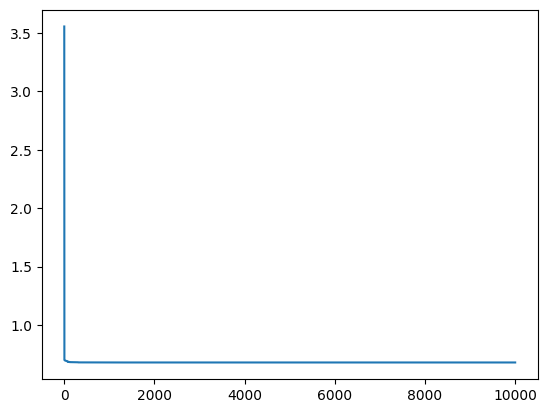

In [84]:
W, error = regression(X_train, y_train, k)

In [85]:
error

0.679177461701496

In [86]:
y_predict = predict(W, X_test)
y_predict = [0 if pred < 0.5 else 1 for pred in y_predict]

In [87]:
print(classification_report(y_pred=y_predict, y_true=y_test, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.51      0.58      0.54       457
           1       0.56      0.49      0.52       503

    accuracy                           0.53       960
   macro avg       0.53      0.53      0.53       960
weighted avg       0.53      0.53      0.53       960



In [89]:
with open('./weights/RegLog/HOG/W.npy', 'wb') as f:
    np.save(f, W)

## LBP

In [90]:
df = pd.read_parquet(r'../../data/preprocessed/feature_matrix_lbp.parquet')

In [91]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,match
0,0.624000,0.0,0.0,0.0,0.673524,0.0,0.0,0.0,0.367238,0.0,...,0.502857,0.0,0.0,0.0,0.448762,0.0,0.0,0.0,0.417524,True
1,0.729143,0.0,0.0,0.0,0.736762,0.0,0.0,0.0,0.450286,0.0,...,0.271238,0.0,0.0,0.0,0.848762,0.0,0.0,0.0,0.412190,True
2,0.688000,0.0,0.0,0.0,0.857905,0.0,0.0,0.0,0.317714,0.0,...,0.561524,0.0,0.0,0.0,0.592000,0.0,0.0,0.0,0.550095,True
3,0.652190,0.0,0.0,0.0,0.876190,0.0,0.0,0.0,0.513524,0.0,...,0.228571,0.0,0.0,0.0,0.623238,0.0,0.0,0.0,0.579048,True
4,0.670476,0.0,0.0,0.0,0.649143,0.0,0.0,0.0,0.673524,0.0,...,0.369524,0.0,0.0,0.0,0.711619,0.0,0.0,0.0,0.518857,True


In [92]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

In [93]:
X.shape

(3197, 59)

In [94]:
y = [int(tag is True) for tag in y]

In [95]:
y = np.array(y)

Separando dados de treino e teste.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [97]:
# número de saídas
k = 1

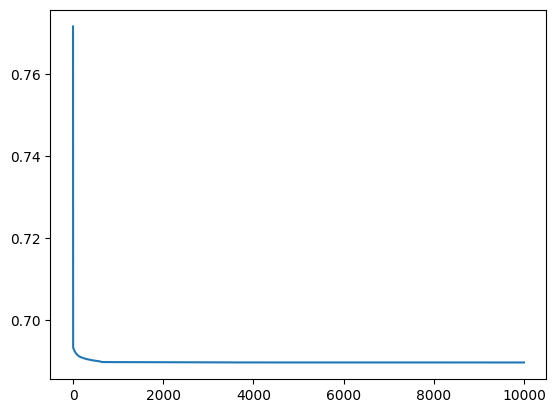

In [98]:
W, error = regression(X_train, y_train, k)

In [99]:
error

0.6896597576515874

In [100]:
y_predict = predict(W, X_test)
y_predict = [0 if pred < 0.5 else 1 for pred in y_predict]

In [101]:
print(classification_report(y_pred=y_predict, y_true=y_test, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.49      0.59      0.53       457
           1       0.54      0.44      0.48       503

    accuracy                           0.51       960
   macro avg       0.51      0.51      0.51       960
weighted avg       0.52      0.51      0.51       960



In [102]:
with open('./weights/RegLog/LBP/W.npy', 'wb') as f:
    np.save(f, W)